# Method 5 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

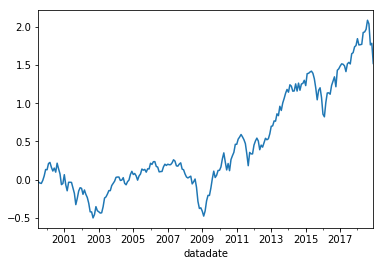

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.130723
2000-12-31   -0.162332
2001-12-31   -0.057835
2002-12-31   -0.337823
2003-12-31    0.655104
2004-12-31    0.131840
2005-12-31    0.028574
2006-12-31    0.040077
2007-12-31   -0.047650
2008-12-31   -0.442338
2009-12-31    0.778403
2010-12-31    0.306491
2011-12-31   -0.086250
2012-12-31    0.196615
2013-12-31    0.364489
2014-12-31    0.055039
2015-12-31   -0.098465
2016-12-31    0.181677
2017-12-31    0.124385
2018-12-31   -0.085121
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     654.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.36e-124
Time:                        04:28:07   Log-Likelihood:                 608.23
No. Observations:                 234   AIC:                            -1206.
Df Residuals:                     229   BIC:                            -1189.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.859      0.064      -0.000       0.005
mktrf          1.0603      0.034     31.269      0.000       0.993       1.127
me             0.2859      0.039      7.248      0.000       0.208       0.364
ia             0.1787      0.060      2.982      0.003       0.061       0.297
roe           -0.5627      0.051    -10.967      0.000      -0.664      -0.462
==============================================================================
Omnibus:                       48.853   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.770
Skew:                           0.792   Prob(JB):                     3.38e-40
Kurtosis:                       7.016   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     281.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.13e-87
Time:                        04:28:07   Log-Likelihood:                 608.23
No. Observations:                 234   AIC:                            -1206.
Df Residuals:                     229   BIC:                            -1189.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.734      0.083      -0.000       0.005
mktrf          1.0603      0.050     20.998      0.000       0.961       1.159
me             0.2859      0.102      2.804      0.005       0.086       0.486
ia             0.1787      0.119      1.503      0.133      -0.054       0.412
roe           -0.5627      0.100     -5.650      0.000      -0.758      -0.368
==============================================================================
Omnibus:                       48.853   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.770
Skew:                           0.792   Prob(JB):                     3.38e-40
Kurtosis:                       7.016   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     247.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.56e-82
Time:                        04:28:07   Log-Likelihood:                 608.23
No. Observations:                 234   AIC:                            -1206.
Df Residuals:                     229   BIC:                            -1189.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.670      0.095      -0.000       0.005
mktrf          1.0603      0.056     18.779      0.000       0.950       1.171
me             0.2859      0.112      2.557      0.011       0.067       0.505
ia             0.1787      0.114      1.564      0.118      -0.045       0.403
roe           -0.5627      0.112     -5.035      0.000      -0.782      -0.344
==============================================================================
Omnibus:                       48.853   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.770
Skew:                           0.792   Prob(JB):                     3.38e-40
Kurtosis:                       7.016   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     427.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.27e-113
Time:                        04:28:07   Log-Likelihood:                 587.08
No. Observations:                 234   AIC:                            -1162.
Df Residuals:                     228   BIC:                            -1141.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.063      0.289      -0.001       0.004
mktrf          1.1228      0.037     30.127      0.000       1.049       1.196
smb            0.3534      0.049      7.186      0.000       0.256       0.450
hml            0.2496      0.058      4.305      0.000       0.135       0.364
rmw           -0.4217      0.066     -6.432      0.000      -0.551      -0.293
cma           -0.0529      0.083     -0.635      0.526      -0.217       0.111
==============================================================================
Omnibus:                       63.727   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.033
Skew:                           1.126   Prob(JB):                     4.95e-45
Kurtosis:                       6.982   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     208.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.36e-83
Time:                        04:28:07   Log-Likelihood:                 587.08
No. Observations:                 234   AIC:                            -1162.
Df Residuals:                     228   BIC:                            -1141.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.899      0.369      -0.002       0.005
mktrf          1.1228      0.043     26.384      0.000       1.039       1.206
smb            0.3534      0.104      3.382      0.001       0.149       0.558
hml            0.2496      0.097      2.569      0.010       0.059       0.440
rmw           -0.4217      0.113     -3.718      0.000      -0.644      -0.199
cma           -0.0529      0.165     -0.320      0.749      -0.377       0.271
==============================================================================
Omnibus:                       63.727   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.033
Skew:                           1.126   Prob(JB):                     4.95e-45
Kurtosis:                       6.982   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     209.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.48e-83
Time:                        04:28:07   Log-Likelihood:                 587.08
No. Observations:                 234   AIC:                            -1162.
Df Residuals:                     228   BIC:                            -1141.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.806      0.420      -0.002       0.005
mktrf          1.1228      0.044     25.386      0.000       1.036       1.210
smb            0.3534      0.105      3.360      0.001       0.147       0.560
hml            0.2496      0.079      3.166      0.002       0.095       0.404
rmw           -0.4217      0.123     -3.426      0.001      -0.663      -0.180
cma           -0.0529      0.164     -0.322      0.747      -0.375       0.269
==============================================================================
Omnibus:                       63.727   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.033
Skew:                           1.126   Prob(JB):                     4.95e-45
Kurtosis:                       6.982   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     790.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.68e-133
Time:                        04:28:07   Log-Likelihood:                 628.82
No. Observations:                 234   AIC:                            -1248.
Df Residuals:                     229   BIC:                            -1230.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.906      0.366      -0.001       0.003
mktrf          1.0922      0.029     38.202      0.000       1.036       1.149
smb            0.5745      0.036     16.099      0.000       0.504       0.645
hml            0.1083      0.035      3.055      0.003       0.038       0.178
umd           -0.2969      0.023    -12.765      0.000      -0.343      -0.251
==============================================================================
Omnibus:                       37.217   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.460
Skew:                           0.727   Prob(JB):                     3.75e-20
Kurtosis:                       5.657   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     341.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.28e-95
Time:                        04:28:07   Log-Likelihood:                 628.82
No. Observations:                 234   AIC:                            -1248.
Df Residuals:                     229   BIC:                            -1230.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.833      0.405      -0.001       0.003
mktrf          1.0922      0.034     31.945      0.000       1.025       1.159
smb            0.5745      0.059      9.673      0.000       0.458       0.691
hml            0.1083      0.050      2.175      0.030       0.011       0.206
umd           -0.2969      0.040     -7.407      0.000      -0.375      -0.218
==============================================================================
Omnibus:                       37.217   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.460
Skew:                           0.727   Prob(JB):                     3.75e-20
Kurtosis:                       5.657   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     296.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-89
Time:                        04:28:07   Log-Likelihood:                 628.82
No. Observations:                 234   AIC:                            -1248.
Df Residuals:                     229   BIC:                            -1230.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.871      0.384      -0.001       0.003
mktrf          1.0922      0.038     28.435      0.000       1.017       1.167
smb            0.5745      0.067      8.569      0.000       0.443       0.706
hml            0.1083      0.045      2.423      0.015       0.021       0.196
umd           -0.2969      0.040     -7.451      0.000      -0.375      -0.219
==============================================================================
Omnibus:                       37.217   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.460
Skew:                           0.727   Prob(JB):                     3.75e-20
Kurtosis:                       5.657   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     319.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.69e-61
Time:                        04:28:07   Log-Likelihood:                 294.42
No. Observations:                 120   AIC:                            -578.8
Df Residuals:                     115   BIC:                            -564.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.907      0.059      -0.000       0.008
mktrf          1.0610      0.055     19.367      0.000       0.952       1.169
me             0.1719      0.054      3.177      0.002       0.065       0.279
ia             0.1667      0.085      1.968      0.051      -0.001       0.335
roe           -0.5830      0.075     -7.774      0.000      -0.732      -0.434
==============================================================================
Omnibus:                       11.495   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.948
Skew:                           0.446   Prob(JB):                     0.000127
Kurtosis:                       4.672   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     154.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.71e-45
Time:                        04:28:07   Log-Likelihood:                 294.42
No. Observations:                 120   AIC:                            -578.8
Df Residuals:                     115   BIC:                            -564.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.870      0.062      -0.000       0.008
mktrf          1.0610      0.064     16.569      0.000       0.935       1.186
me             0.1719      0.092      1.876      0.061      -0.008       0.352
ia             0.1667      0.134      1.245      0.213      -0.096       0.429
roe           -0.5830      0.115     -5.074      0.000      -0.808      -0.358
==============================================================================
Omnibus:                       11.495   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.948
Skew:                           0.446   Prob(JB):                     0.000127
Kurtosis:                       4.672   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     124.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.29e-41
Time:                        04:28:07   Log-Likelihood:                 294.42
No. Observations:                 120   AIC:                            -578.8
Df Residuals:                     115   BIC:                            -564.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.888      0.059      -0.000       0.008
mktrf          1.0610      0.073     14.627      0.000       0.919       1.203
me             0.1719      0.100      1.720      0.085      -0.024       0.368
ia             0.1667      0.129      1.291      0.197      -0.086       0.420
roe           -0.5830      0.129     -4.503      0.000      -0.837      -0.329
==============================================================================
Omnibus:                       11.495   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.948
Skew:                           0.446   Prob(JB):                     0.000127
Kurtosis:                       4.672   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     197.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.81e-54
Time:                        04:28:07   Log-Likelihood:                 280.94
No. Observations:                 120   AIC:                            -549.9
Df Residuals:                     114   BIC:                            -533.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.648      0.102      -0.001       0.009
mktrf          1.1853      0.065     18.258      0.000       1.057       1.314
smb            0.2513      0.074      3.418      0.001       0.106       0.397
hml            0.1906      0.090      2.115      0.037       0.012       0.369
rmw           -0.3994      0.106     -3.759      0.000      -0.610      -0.189
cma           -0.0151      0.116     -0.130      0.897      -0.246       0.216
==============================================================================
Omnibus:                       25.471   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.683
Skew:                           0.939   Prob(JB):                     1.98e-10
Kurtosis:                       5.326   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     80.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.67e-36
Time:                        04:28:07   Log-Likelihood:                 280.94
No. Observations:                 120   AIC:                            -549.9
Df Residuals:                     114   BIC:                            -533.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.561      0.119      -0.001       0.009
mktrf          1.1853      0.066     18.089      0.000       1.057       1.314
smb            0.2513      0.127      1.976      0.048       0.002       0.501
hml            0.1906      0.103      1.859      0.063      -0.010       0.392
rmw           -0.3994      0.130     -3.080      0.002      -0.654      -0.145
cma           -0.0151      0.189     -0.080      0.936      -0.385       0.355
==============================================================================
Omnibus:                       25.471   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.683
Skew:                           0.939   Prob(JB):                     1.98e-10
Kurtosis:                       5.326   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     72.64
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.09e-34
Time:                        04:28:08   Log-Likelihood:                 280.94
No. Observations:                 120   AIC:                            -549.9
Df Residuals:                     114   BIC:                            -533.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.439      0.150      -0.001       0.009
mktrf          1.1853      0.064     18.631      0.000       1.061       1.310
smb            0.2513      0.121      2.083      0.037       0.015       0.488
hml            0.1906      0.088      2.167      0.030       0.018       0.363
rmw           -0.3994      0.137     -2.920      0.003      -0.667      -0.131
cma           -0.0151      0.185     -0.082      0.935      -0.377       0.347
==============================================================================
Omnibus:                       25.471   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.683
Skew:                           0.939   Prob(JB):                     1.98e-10
Kurtosis:                       5.326   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     412.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.51e-67
Time:                        04:28:08   Log-Likelihood:                 308.58
No. Observations:                 120   AIC:                            -607.2
Df Residuals:                     115   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.443      0.152      -0.001       0.006
mktrf          1.1269      0.043     26.274      0.000       1.042       1.212
smb            0.5038      0.049     10.316      0.000       0.407       0.601
hml            0.0481      0.049      0.983      0.328      -0.049       0.145
umd           -0.2939      0.030     -9.746      0.000      -0.354      -0.234
==============================================================================
Omnibus:                        8.989   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.733
Skew:                           0.408   Prob(JB):                      0.00283
Kurtosis:                       4.296   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     281.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.29e-58
Time:                        04:28:08   Log-Likelihood:                 308.58
No. Observations:                 120   AIC:                            -607.2
Df Residuals:                     115   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.386      0.166      -0.001       0.006
mktrf          1.1269      0.050     22.411      0.000       1.028       1.225
smb            0.5038      0.063      8.015      0.000       0.381       0.627
hml            0.0481      0.063      0.768      0.442      -0.075       0.171
umd           -0.2939      0.043     -6.770      0.000      -0.379      -0.209
==============================================================================
Omnibus:                        8.989   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.733
Skew:                           0.408   Prob(JB):                      0.00283
Kurtosis:                       4.296   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     347.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.48e-63
Time:                        04:28:08   Log-Likelihood:                 308.58
No. Observations:                 120   AIC:                            -607.2
Df Residuals:                     115   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.530      0.126      -0.001       0.006
mktrf          1.1269      0.057     19.921      0.000       1.016       1.238
smb            0.5038      0.074      6.816      0.000       0.359       0.649
hml            0.0481      0.063      0.762      0.446      -0.076       0.172
umd           -0.2939      0.041     -7.164      0.000      -0.374      -0.214
==============================================================================
Omnibus:                        8.989   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.733
Skew:                           0.408   Prob(JB):                      0.00283
Kurtosis:                       4.296   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     510.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-69
Time:                        04:28:08   Log-Likelihood:                 346.11
No. Observations:                 114   AIC:                            -682.2
Df Residuals:                     109   BIC:                            -668.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.844      0.068      -0.000       0.005
mktrf          0.9796      0.035     28.036      0.000       0.910       1.049
me             0.6321      0.054     11.717      0.000       0.525       0.739
ia             0.1544      0.075      2.063      0.041       0.006       0.303
roe           -0.5415      0.066     -8.235      0.000      -0.672      -0.411
==============================================================================
Omnibus:                      109.314   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.783
Skew:                           3.072   Prob(JB):                         0.00
Kurtosis:                      21.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     372.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-62
Time:                        04:28:08   Log-Likelihood:                 346.11
No. Observations:                 114   AIC:                            -682.2
Df Residuals:                     109   BIC:                            -668.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.510      0.131      -0.001       0.005
mktrf          0.9796      0.031     31.640      0.000       0.919       1.040
me             0.6321      0.048     13.089      0.000       0.537       0.727
ia             0.1544      0.081      1.907      0.057      -0.004       0.313
roe           -0.5415      0.099     -5.467      0.000      -0.736      -0.347
==============================================================================
Omnibus:                      109.314   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.783
Skew:                           3.072   Prob(JB):                         0.00
Kurtosis:                      21.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     362.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.92e-62
Time:                        04:28:08   Log-Likelihood:                 346.11
No. Observations:                 114   AIC:                            -682.2
Df Residuals:                     109   BIC:                            -668.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.603      0.109      -0.000       0.005
mktrf          0.9796      0.031     31.957      0.000       0.919       1.040
me             0.6321      0.056     11.363      0.000       0.523       0.741
ia             0.1544      0.085      1.810      0.070      -0.013       0.322
roe           -0.5415      0.099     -5.496      0.000      -0.735      -0.348
==============================================================================
Omnibus:                      109.314   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.783
Skew:                           3.072   Prob(JB):                         0.00
Kurtosis:                      21.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     332.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.50e-64
Time:                        04:28:08   Log-Likelihood:                 335.47
No. Observations:                 114   AIC:                            -658.9
Df Residuals:                     108   BIC:                            -642.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.538      0.592      -0.002       0.003
mktrf          1.0153      0.037     27.627      0.000       0.942       1.088
smb            0.6138      0.060     10.289      0.000       0.496       0.732
hml            0.2660      0.076      3.496      0.001       0.115       0.417
rmw           -0.3889      0.093     -4.175      0.000      -0.574      -0.204
cma           -0.0006      0.118     -0.005      0.996      -0.235       0.234
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.151
Skew:                           1.886   Prob(JB):                     5.53e-72
Kurtosis:                      10.407   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     241.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.04e-57
Time:                        04:28:08   Log-Likelihood:                 335.47
No. Observations:                 114   AIC:                            -658.9
Df Residuals:                     108   BIC:                            -642.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.415      0.678      -0.003       0.004
mktrf          1.0153      0.033     31.002      0.000       0.951       1.079
smb            0.6138      0.055     11.105      0.000       0.505       0.722
hml            0.2660      0.133      1.993      0.046       0.004       0.528
rmw           -0.3889      0.113     -3.450      0.001      -0.610      -0.168
cma           -0.0006      0.113     -0.005      0.996      -0.223       0.222
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.151
Skew:                           1.886   Prob(JB):                     5.53e-72
Kurtosis:                      10.407   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     227.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-55
Time:                        04:28:08   Log-Likelihood:                 335.47
No. Observations:                 114   AIC:                            -658.9
Df Residuals:                     108   BIC:                            -642.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.392      0.695      -0.003       0.004
mktrf          1.0153      0.034     30.230      0.000       0.949       1.081
smb            0.6138      0.058     10.550      0.000       0.500       0.728
hml            0.2660      0.120      2.221      0.026       0.031       0.501
rmw           -0.3889      0.105     -3.710      0.000      -0.594      -0.183
cma           -0.0006      0.103     -0.005      0.996      -0.202       0.201
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.151
Skew:                           1.886   Prob(JB):                     5.53e-72
Kurtosis:                      10.407   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     432.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.69e-66
Time:                        04:28:08   Log-Likelihood:                 337.18
No. Observations:                 114   AIC:                            -664.4
Df Residuals:                     109   BIC:                            -650.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.543      0.588      -0.002       0.003
mktrf          1.0181      0.036     28.433      0.000       0.947       1.089
smb            0.7165      0.056     12.834      0.000       0.606       0.827
hml            0.2696      0.057      4.688      0.000       0.156       0.384
umd           -0.2063      0.043     -4.757      0.000      -0.292      -0.120
==============================================================================
Omnibus:                       55.388   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.447
Skew:                           1.524   Prob(JB):                     3.13e-64
Kurtosis:                      10.230   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     332.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.58e-60
Time:                        04:28:08   Log-Likelihood:                 337.18
No. Observations:                 114   AIC:                            -664.4
Df Residuals:                     109   BIC:                            -650.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.423      0.672      -0.003       0.004
mktrf          1.0181      0.035     28.911      0.000       0.949       1.087
smb            0.7165      0.043     16.785      0.000       0.633       0.800
hml            0.2696      0.095      2.830      0.005       0.083       0.456
umd           -0.2063      0.062     -3.336      0.001      -0.328      -0.085
==============================================================================
Omnibus:                       55.388   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.447
Skew:                           1.524   Prob(JB):                     3.13e-64
Kurtosis:                      10.230   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     342.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.33e-61
Time:                        04:28:08   Log-Likelihood:                 337.18
No. Observations:                 114   AIC:                            -664.4
Df Residuals:                     109   BIC:                            -650.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.002      0.397      0.691      -0.003       0.004
mktrf          1.0181      0.034     29.687      0.000       0.951       1.085
smb            0.7165      0.042     16.894      0.000       0.633       0.800
hml            0.2696      0.097      2.780      0.005       0.079       0.460
umd           -0.2063      0.060     -3.456      0.001      -0.323      -0.089
==============================================================================
Omnibus:                       55.388   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.447
Skew:                           1.524   Prob(JB):                     3.13e-64
Kurtosis:                      10.230   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""